In [1]:
import torch
import matplotlib.pyplot as plt

import time

import os.path as osp
import numpy as np

from dataset import make_dataset
from train import make_data_loader, train_step, test_evaluations
from utils import get_device, plot_training_progress
from model import GCNNetwork, CEALNetwork, save_model, load_model

from args import *
from utils import *

from tqdm import tqdm
from IPython.display import clear_output as ipyclear

/home/catcolia/anaconda3/envs/material/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Prepare the dataset

In [2]:
train_dataset, validation_dataset, test_dataset = make_dataset()
train_loader, val_loader, test_loader = make_data_loader(train_dataset, validation_dataset, test_dataset)

Model training parameters

In [3]:
model_name = "CEAL"
model_network = model_name + "Network"
model_args = args[model_name]

In [4]:
def save_result_data(
    all_args,
    epoch,
    model,
    train_losses,
    val_losses,
    test_losses,
    test_loader,
    test_dataset,
    device,
    optimizer,
    scheduler,
    result_path,
    regression_title="Model Regression",
    save_split=100,
    training=False,
    *args,
    **kwargs
):
    if epoch % save_split != 0 and training is True:
        return

    print("Saving data...")
    save_hyper_parameter(all_args, result_path)
    save_train_progress(epoch - 1, train_losses, val_losses, test_losses, result_path)
    test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)

    # Reverse normalization of test_out and y
    min, max = get_data_scale(all_args)
    test_y = reverse_min_max_scalar_1d(test_y, min, max)
    test_out = reverse_min_max_scalar_1d(test_out, min, max)
    loss = (test_out.squeeze() - test_y).abs().mean()
    print("MAE loss: ", loss.item())

    # save results
    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, res_path=result_path,threshold=0.2)
    save_regression_result(test_out, test_y, result_path)
    plot_regression_result(regression_title, result_path, plotfilename="regression_figure.jpeg")

    # save model
    print("Saving model...")
    save_model(result_path, model, epoch, loss, optimizer, scheduler)

    return loss

In [5]:
print(len(train_dataset), len(validation_dataset), len(test_dataset))

device = get_device()
# device = torch.device("cpu")

in_dim = train_dataset[0].x.shape[-1]
print(in_dim)
deg = generate_deg(train_dataset).float()
deg = deg.to(device)
model = CEALNetwork(deg, in_dim)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=model_args["learning_rate"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode=model_args["sche_mode"], factor=model_args["sche_factor"], patience=model_args["sche_patience"], min_lr=model_args["sche_min_lr"]
)

29274 6273 6272
100


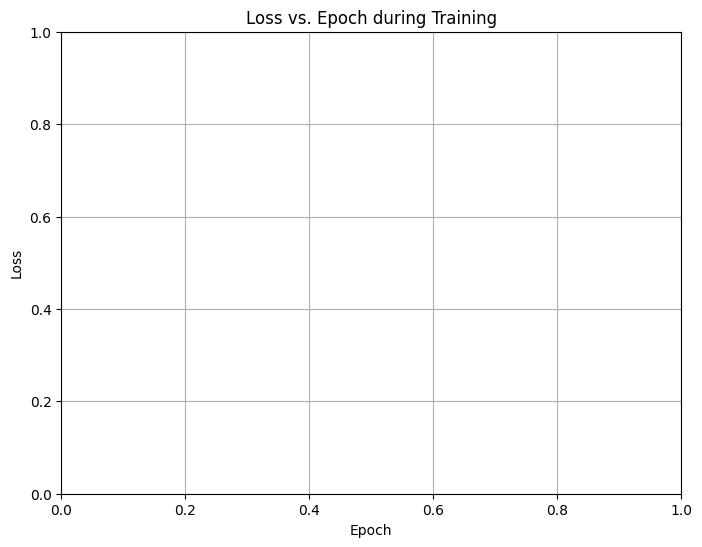

In [6]:
result_path = create_result_folder(osp.join("./results", model_name))
test_best_loss = None
epoch = None

save_split = 100
show_plot_split = 50

with open(osp.join(result_path, "model_info.txt"), "w") as file:
    print(model, file=file)
    file.close()

train_losses = []
test_losses = []
val_losses = []

plt.figure(figsize=(8, 6))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch during Training")
plt.grid(True)

Model training

epoch:49 train:0.0152 valid:0.0176 test:0.0176 lr:0.01 best_test:0.0135:   0%|          | 50/10001 [02:38<8:58:35,  3.25s/it]

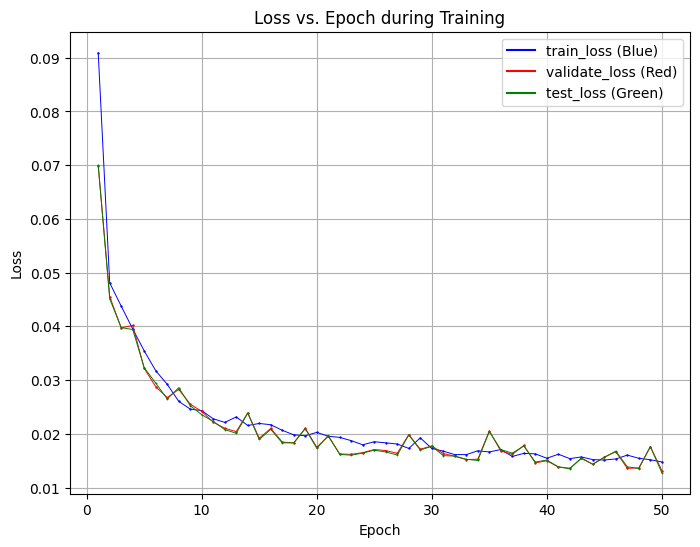

epoch:99 train:0.0129 valid:0.0129 test:0.0131 lr:0.01 best_test:0.011:   1%|          | 100/10001 [05:21<9:01:33,  3.28s/it]

Saving data...
MAE loss:  0.12775996327400208


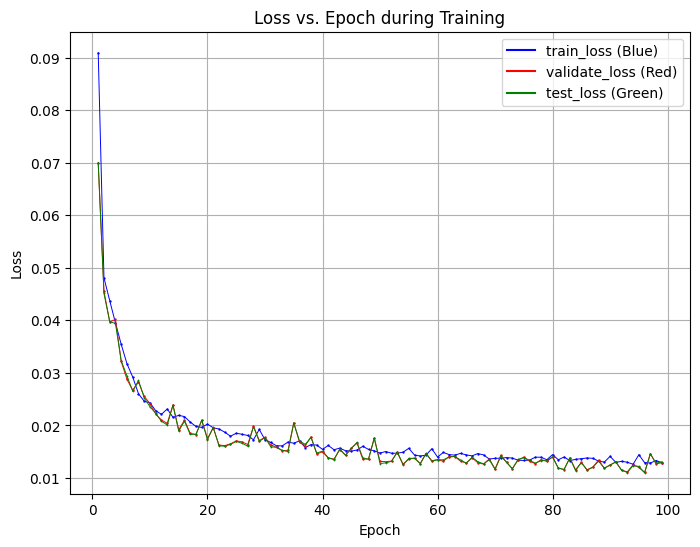

MAE=  0.12775997542934533
Saving model...


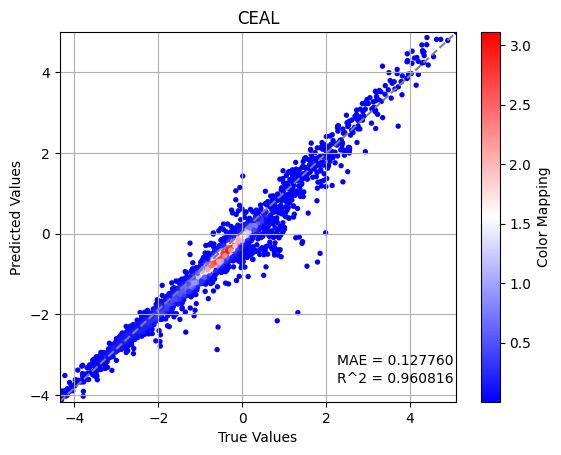

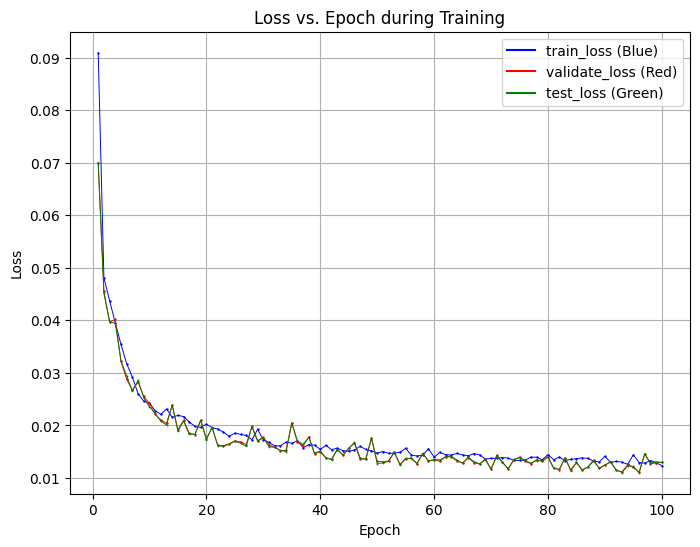

epoch:149 train:0.0123 valid:0.0142 test:0.0144 lr:0.01 best_test:0.0103:   1%|▏         | 150/10001 [08:07<9:01:20,  3.30s/it]

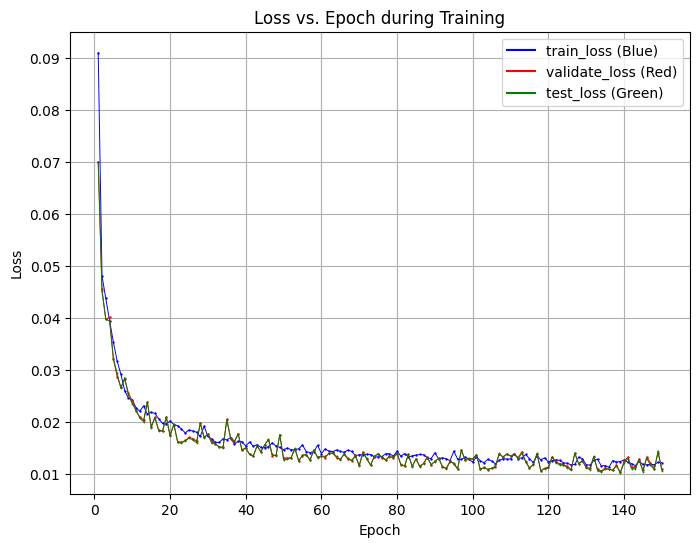

epoch:199 train:0.0118 valid:0.0132 test:0.0133 lr:0.01 best_test:0.0094:   2%|▏         | 200/10001 [10:53<8:57:45,  3.29s/it]

Saving data...
MAE loss:  0.13012778759002686


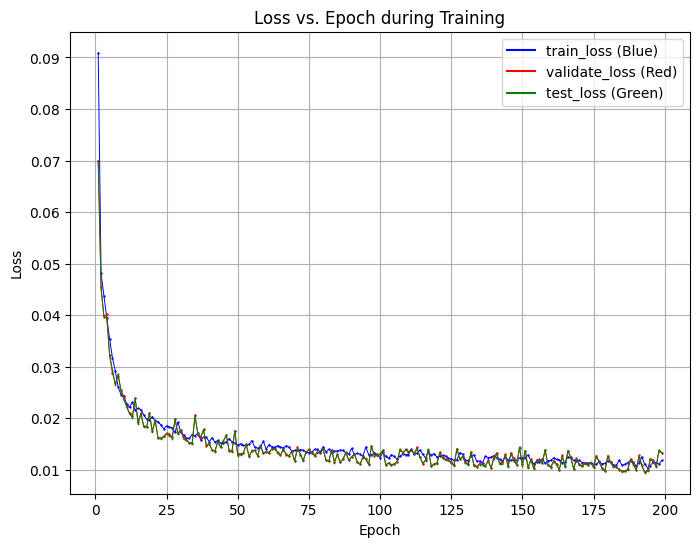

MAE=  0.13012779660597737
Saving model...


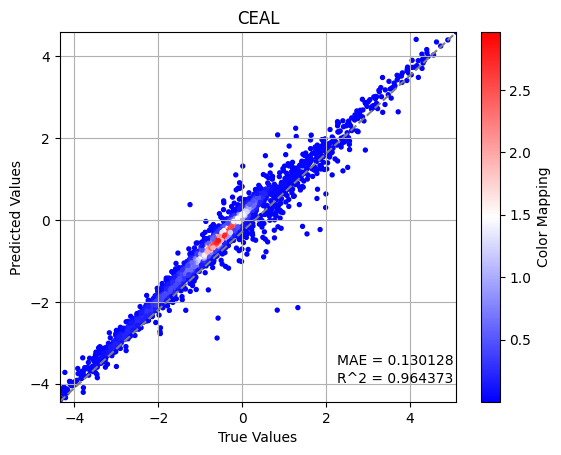

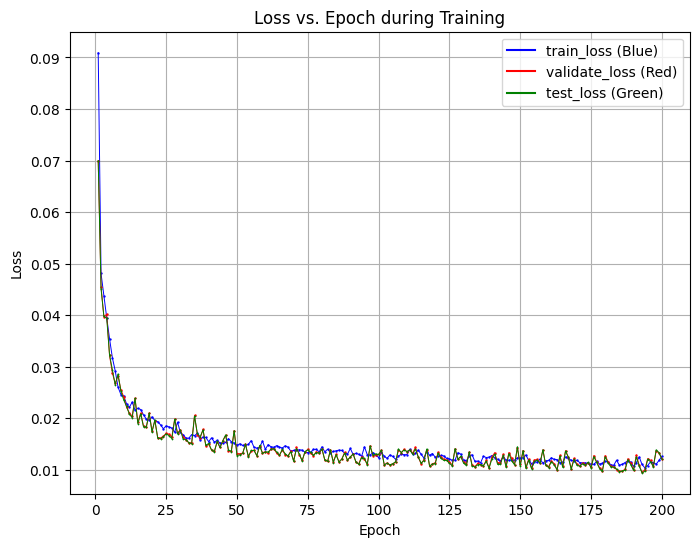

epoch:249 train:0.0101 valid:0.0095 test:0.0093 lr:0.01 best_test:0.0091:   2%|▏         | 250/10001 [13:40<9:00:45,  3.33s/it] 

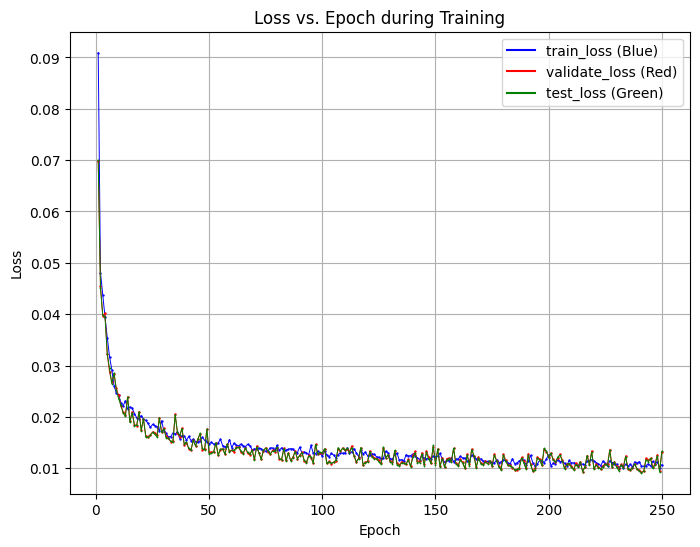

epoch:299 train:0.0096 valid:0.0101 test:0.0101 lr:0.01 best_test:0.0089:   3%|▎         | 300/10001 [16:30<10:41:25,  3.97s/it]

Saving data...
MAE loss:  0.09806595742702484


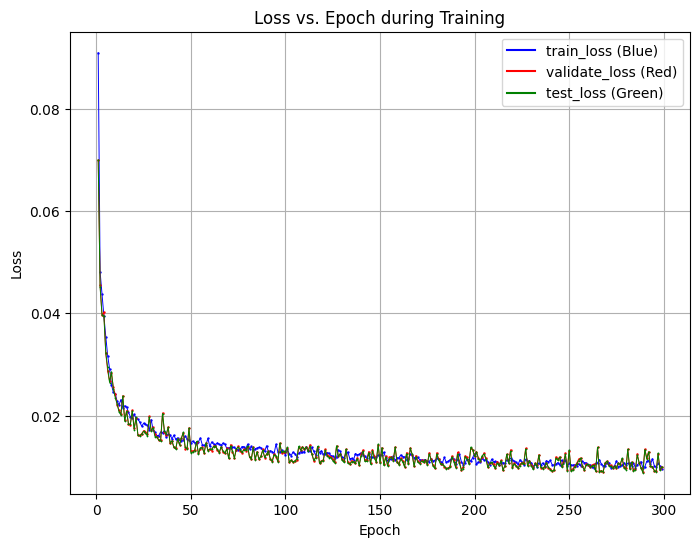

MAE=  0.09806595317707269
Saving model...


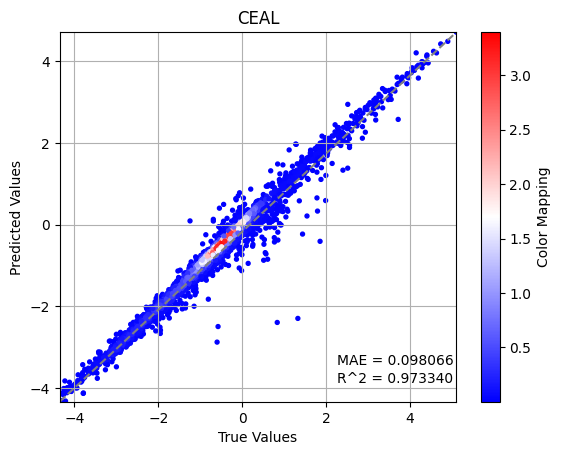

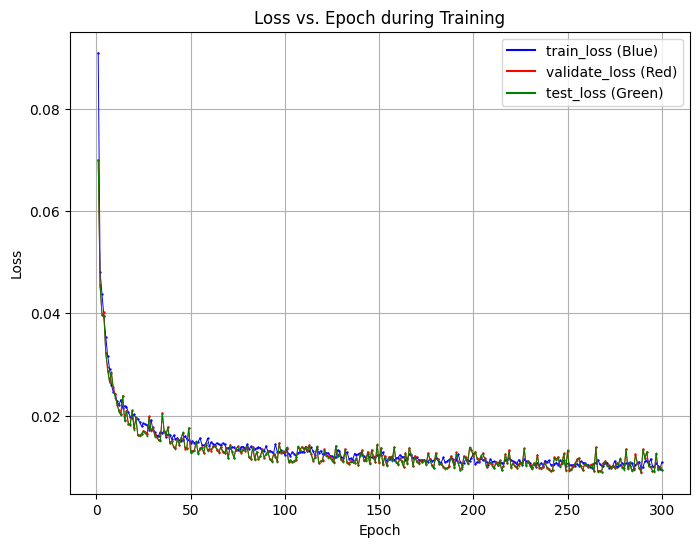

epoch:349 train:0.0092 valid:0.0093 test:0.0092 lr:0.0085 best_test:0.0085:   3%|▎         | 350/10001 [19:31<8:53:46,  3.32s/it]

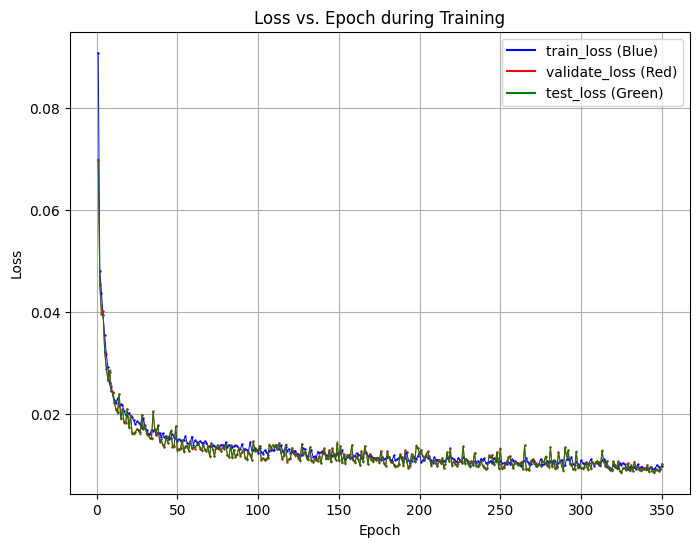

epoch:399 train:0.0094 valid:0.0095 test:0.0095 lr:0.007225 best_test:0.0083:   4%|▍         | 400/10001 [22:18<8:53:21,  3.33s/it]

Saving data...
MAE loss:  0.09230951964855194


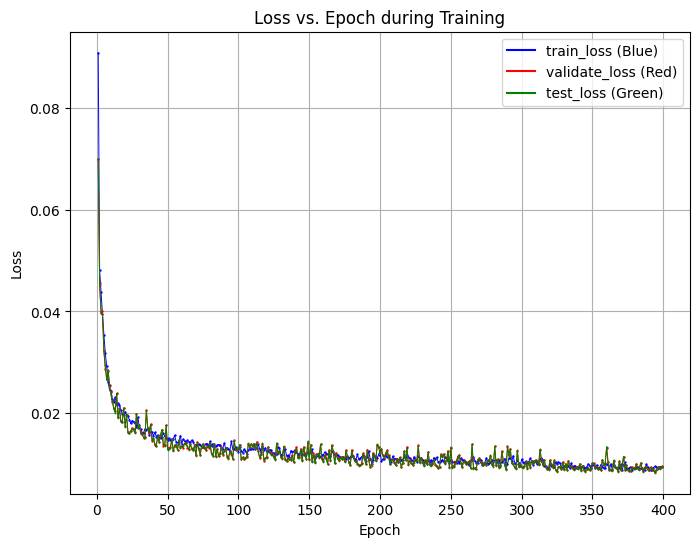

MAE=  0.09230952735512594
Saving model...


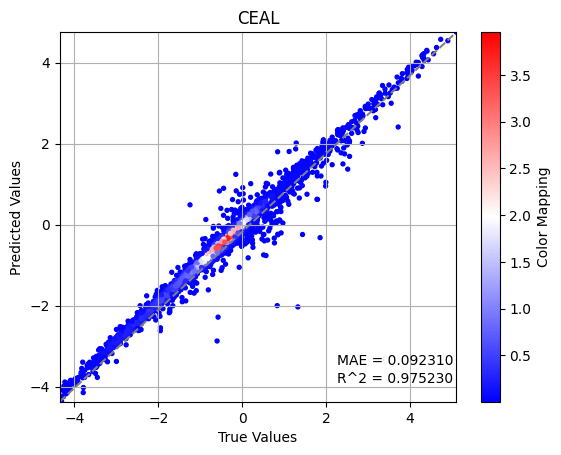

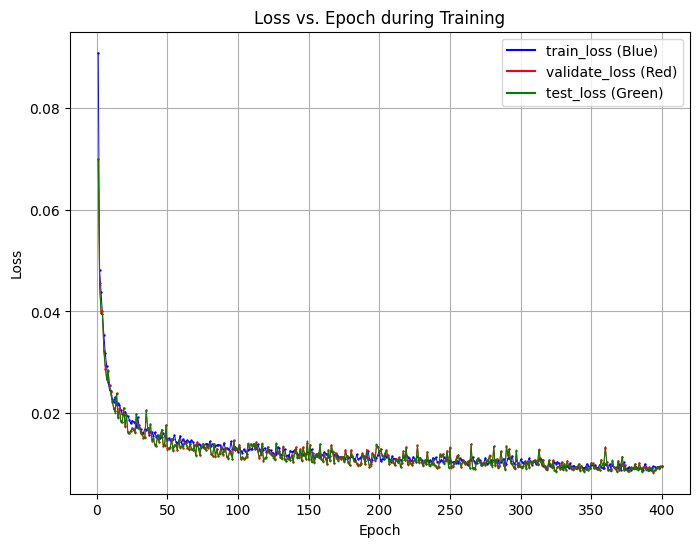

epoch:449 train:0.0087 valid:0.009 test:0.0088 lr:0.00522006 best_test:0.0081:   4%|▍         | 450/10001 [25:06<8:46:39,  3.31s/it] 

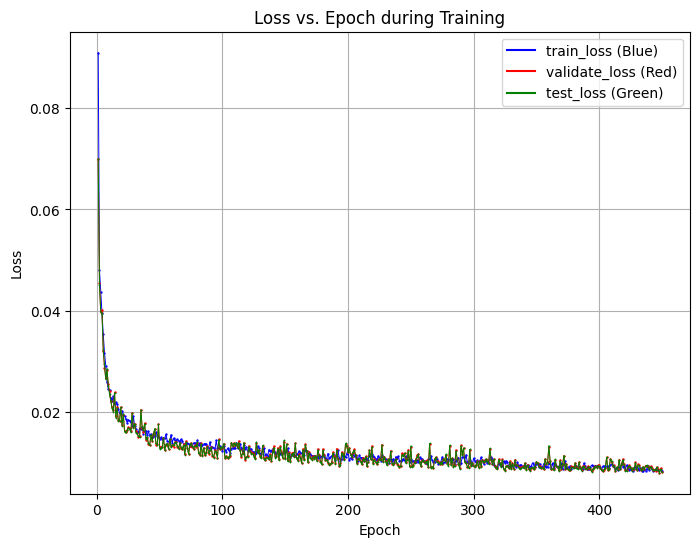

epoch:499 train:0.0079 valid:0.0083 test:0.0083 lr:0.00443705 best_test:0.0079:   5%|▍         | 500/10001 [27:54<8:54:18,  3.37s/it]

Saving data...
MAE loss:  0.0809536725282669


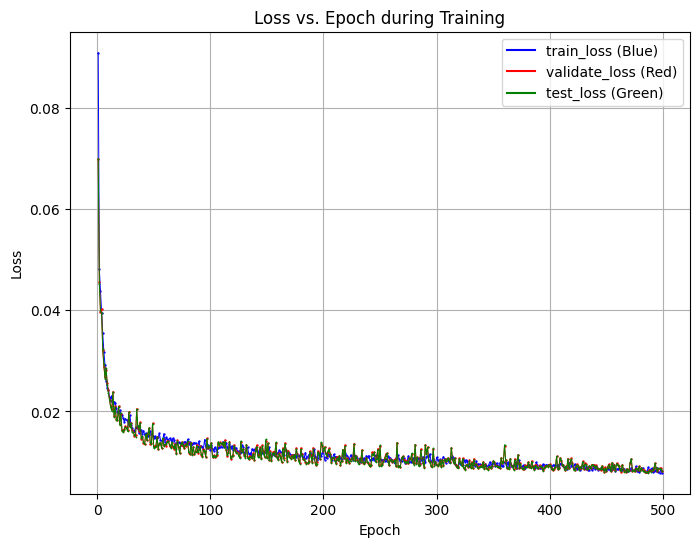

MAE=  0.08095367659265944
Saving model...


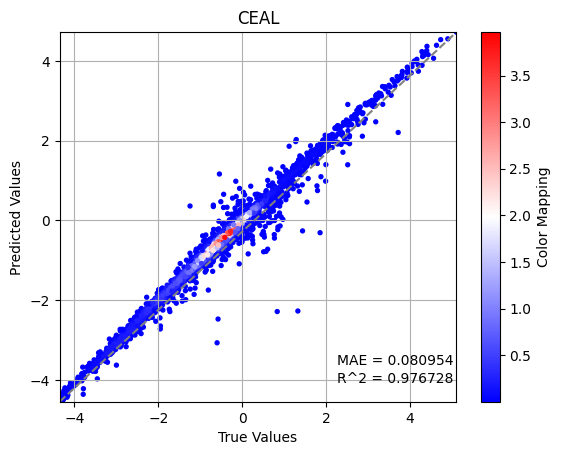

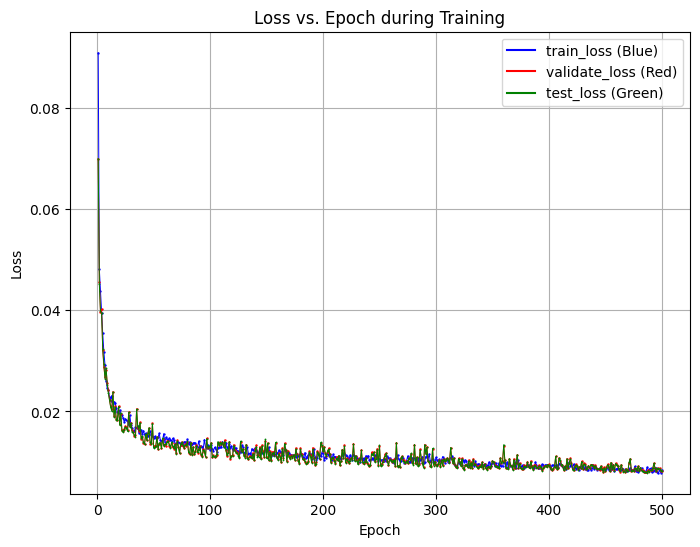

epoch:549 train:0.0078 valid:0.0081 test:0.0082 lr:0.00443705 best_test:0.0078:   5%|▌         | 550/10001 [30:42<8:40:23,  3.30s/it] 

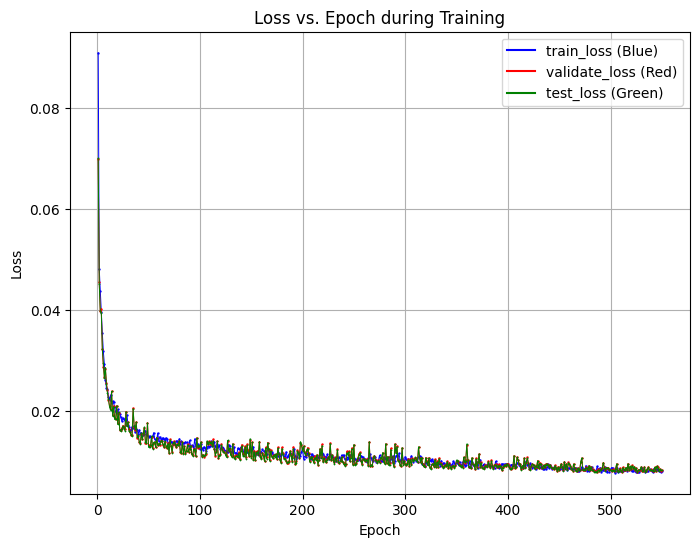

epoch:599 train:0.0079 valid:0.0078 test:0.0079 lr:0.00320577 best_test:0.0078:   6%|▌         | 600/10001 [33:29<8:41:14,  3.33s/it]

Saving data...
MAE loss:  0.07676329463720322


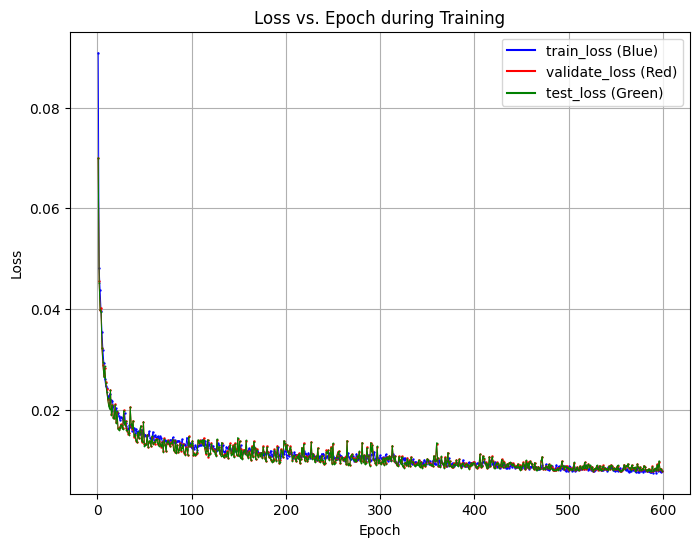

MAE=  0.07676329456578285
Saving model...


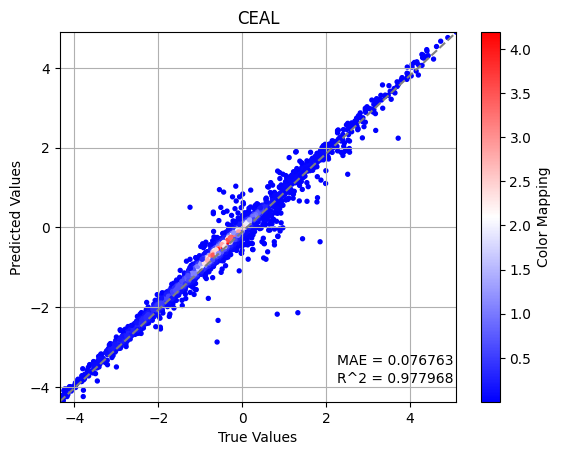

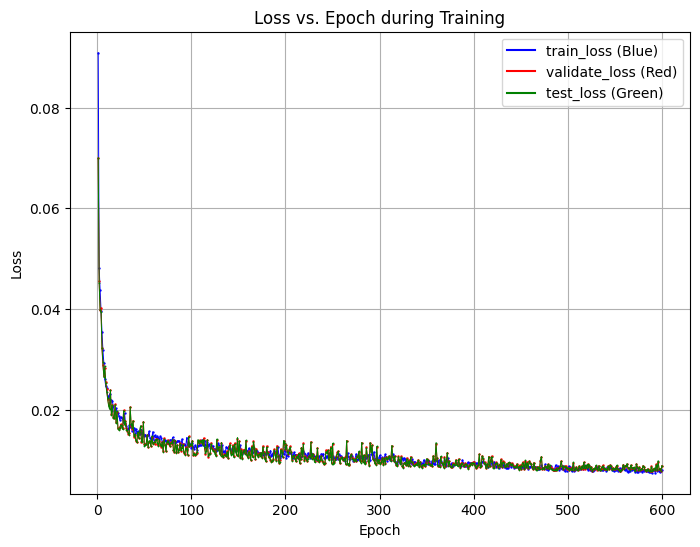

epoch:649 train:0.0075 valid:0.0078 test:0.0078 lr:0.00272491 best_test:0.0077:   6%|▋         | 650/10001 [36:17<8:38:09,  3.32s/it]

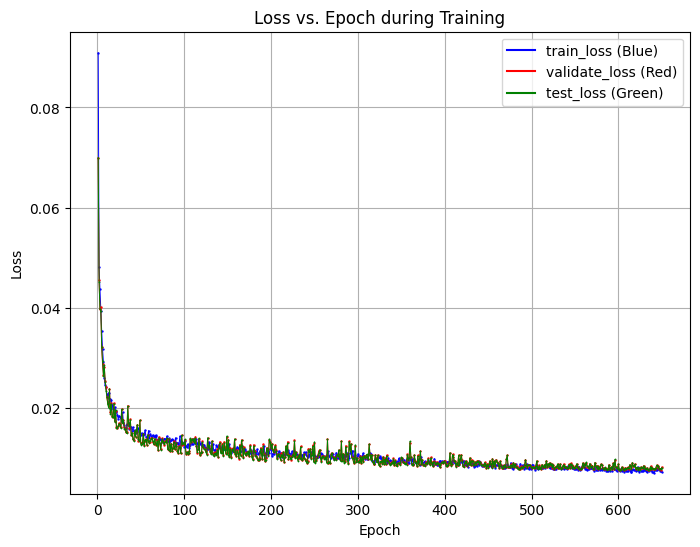

epoch:699 train:0.0075 valid:0.0086 test:0.0087 lr:0.00196874 best_test:0.0077:   7%|▋         | 700/10001 [39:05<8:47:07,  3.40s/it]

Saving data...
MAE loss:  0.08481980860233307


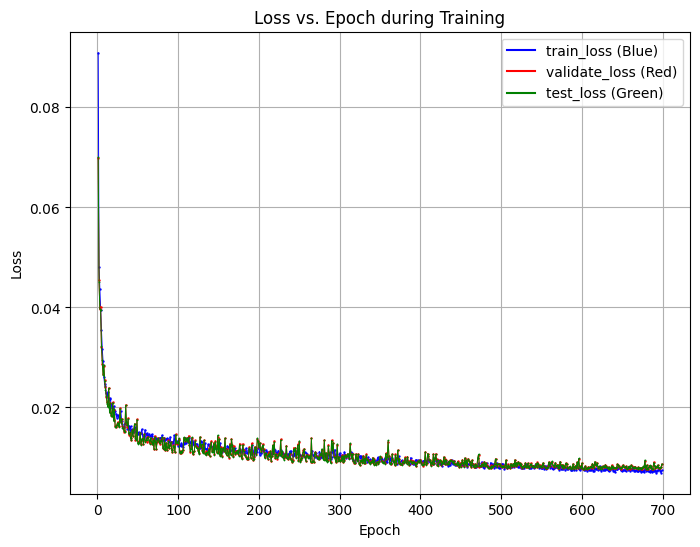

MAE=  0.08481980677075414
Saving model...


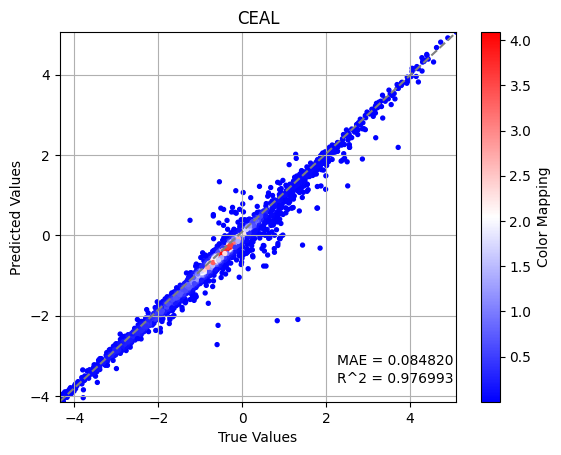

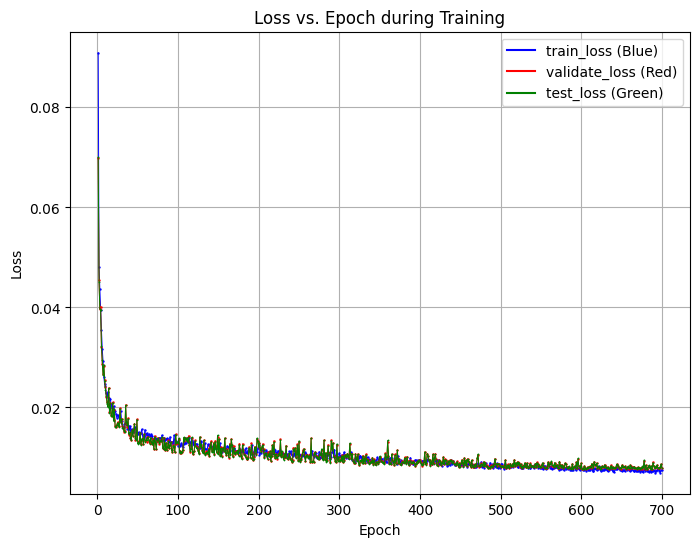

epoch:749 train:0.0072 valid:0.008 test:0.008 lr:0.00196874 best_test:0.0076:   7%|▋         | 750/10001 [41:55<8:55:01,  3.47s/it]   

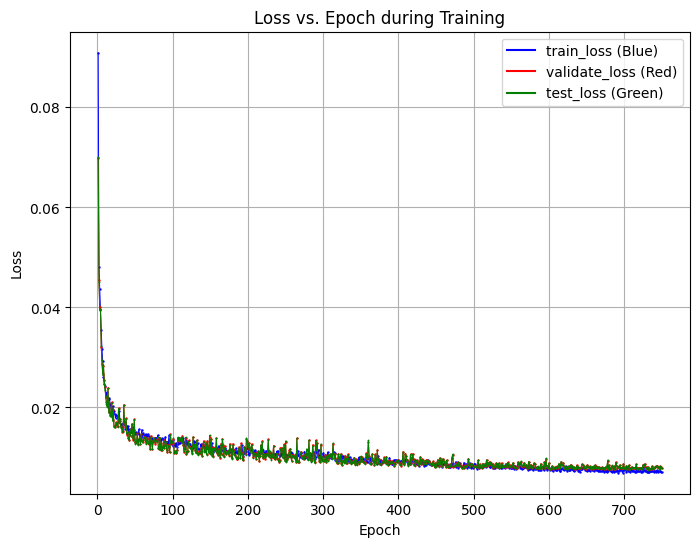

epoch:799 train:0.0068 valid:0.0077 test:0.0076 lr:0.00142242 best_test:0.0076:   8%|▊         | 800/10001 [45:59<14:00:27,  5.48s/it]

Saving data...
MAE loss:  0.07422445714473724


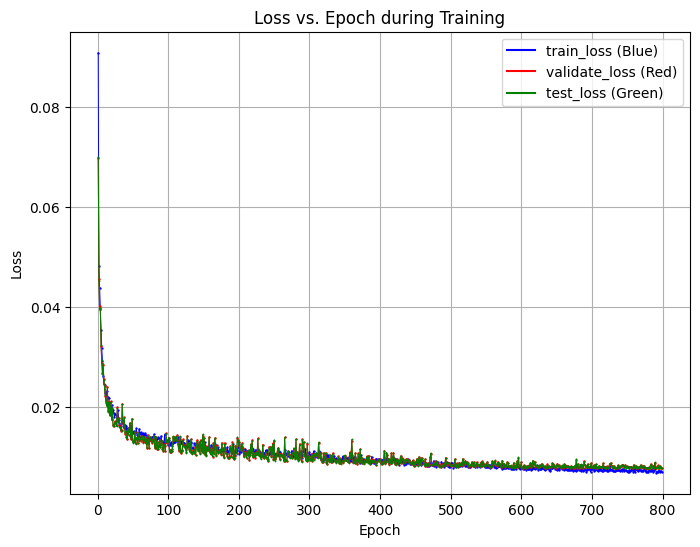

MAE=  0.07422446397263871
Saving model...


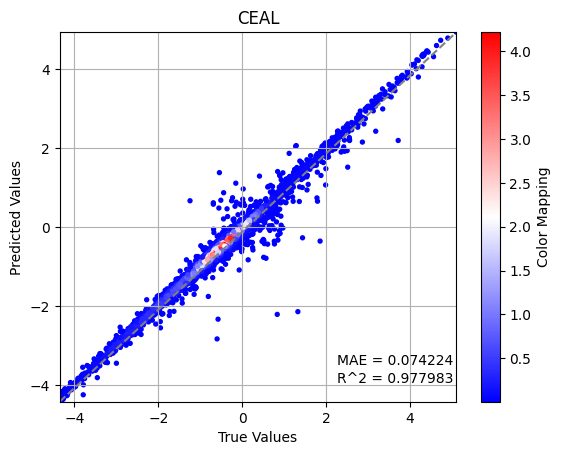

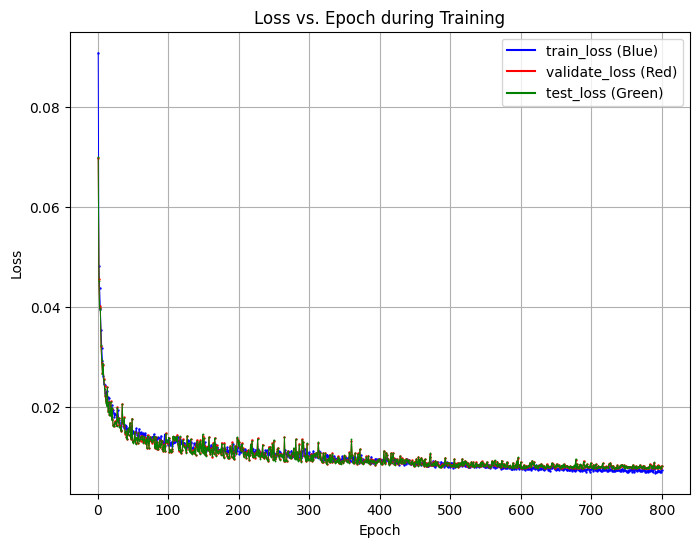

epoch:849 train:0.0068 valid:0.0077 test:0.0077 lr:0.0010277 best_test:0.0075:   8%|▊         | 850/10001 [48:47<8:23:21,  3.30s/it]  

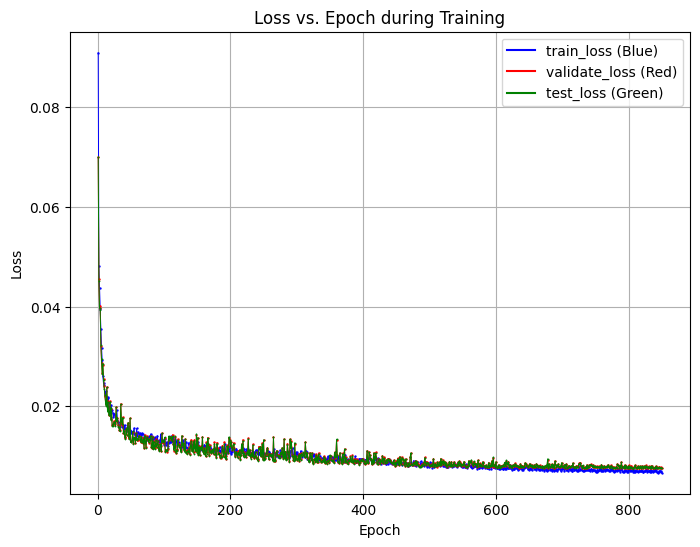

epoch:899 train:0.0068 valid:0.0077 test:0.0076 lr:0.00087354 best_test:0.0075:   9%|▉         | 900/10001 [51:34<8:26:40,  3.34s/it]

Saving data...
MAE loss:  0.07458708435297012


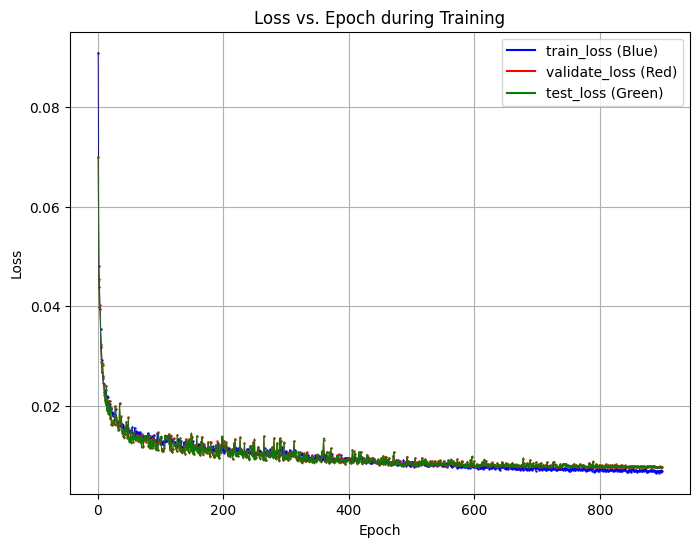

MAE=  0.07458708188597417
Saving model...


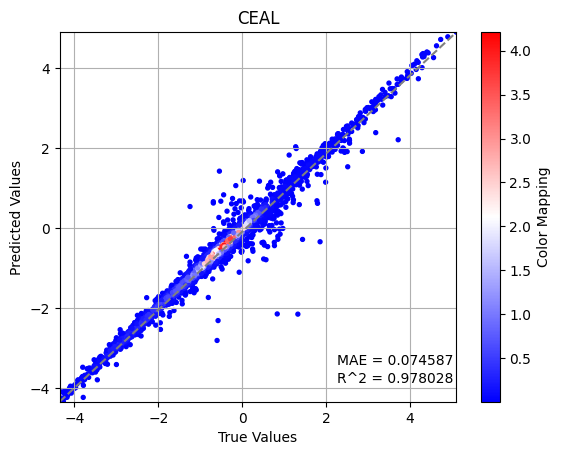

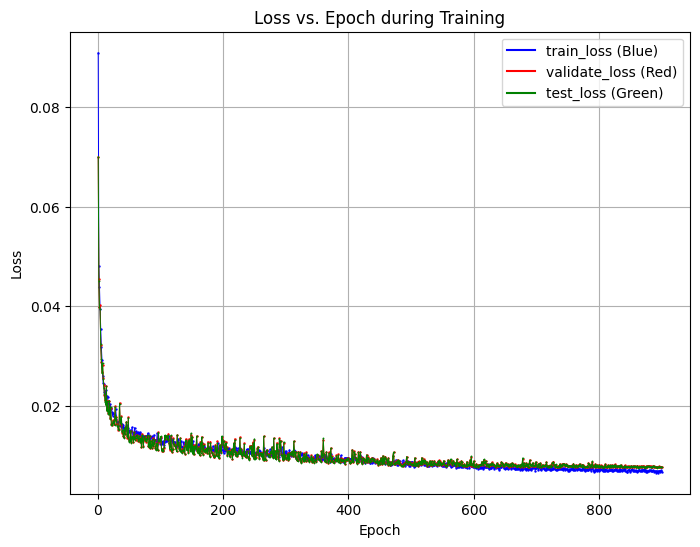

epoch:949 train:0.0067 valid:0.0076 test:0.0076 lr:0.00063113 best_test:0.0075:   9%|▉         | 950/10001 [54:23<8:22:55,  3.33s/it]

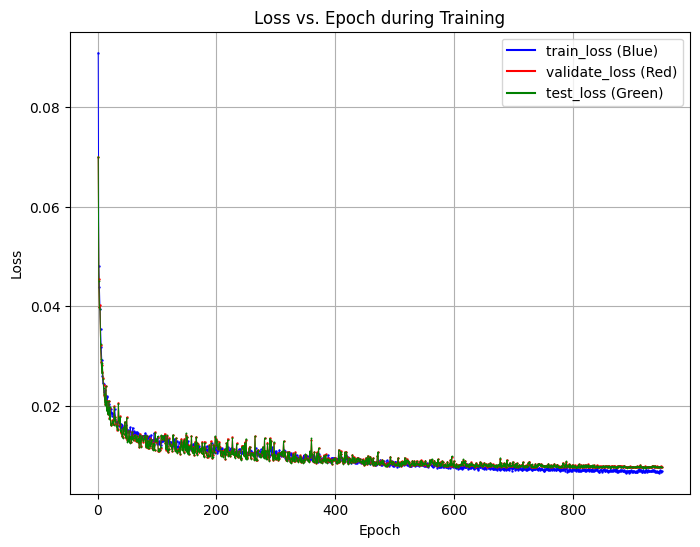

epoch:999 train:0.0066 valid:0.0076 test:0.0076 lr:0.00045599 best_test:0.0075:  10%|▉         | 1000/10001 [57:11<8:20:09,  3.33s/it]

Saving data...
MAE loss:  0.07380404323339462


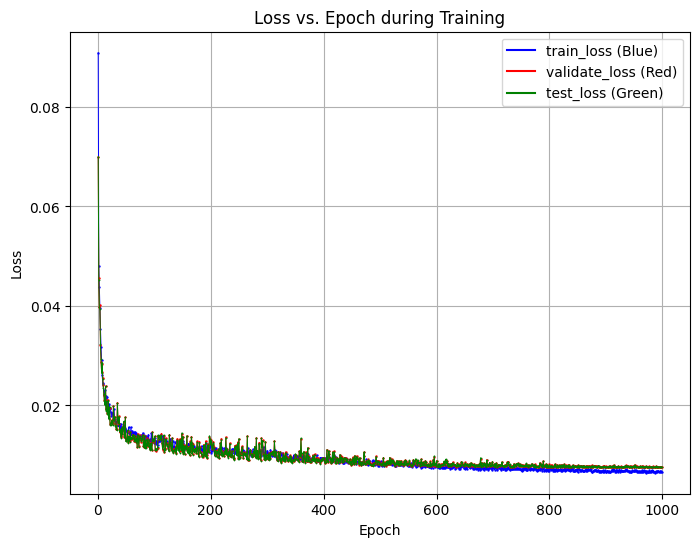

MAE=  0.07380404715659916
Saving model...


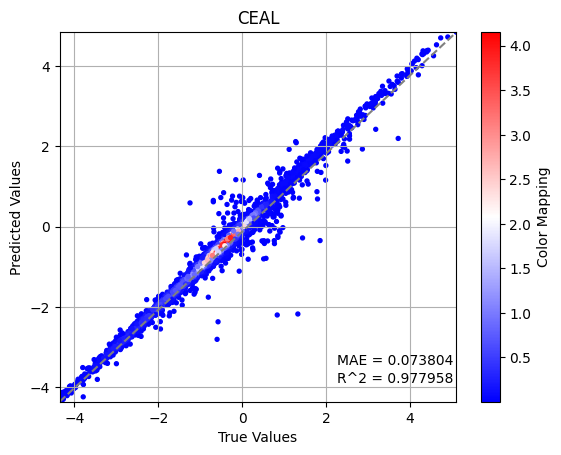

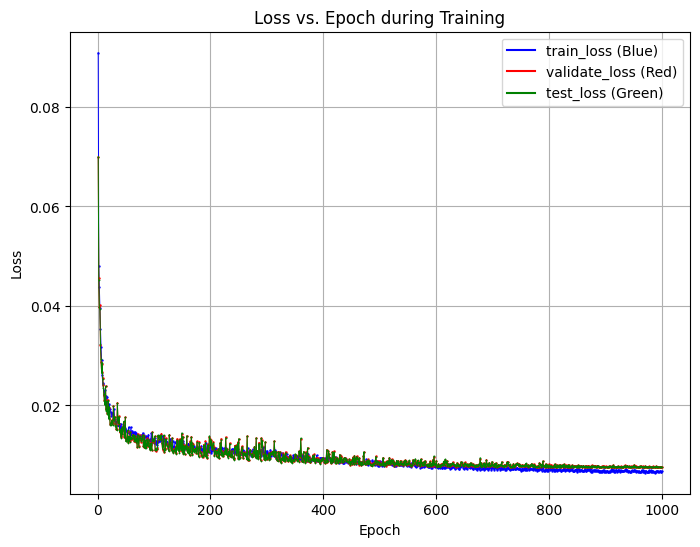

epoch:1049 train:0.0067 valid:0.0076 test:0.0075 lr:0.00032946 best_test:0.0075:  10%|█         | 1050/10001 [1:00:00<8:21:01,  3.36s/it]

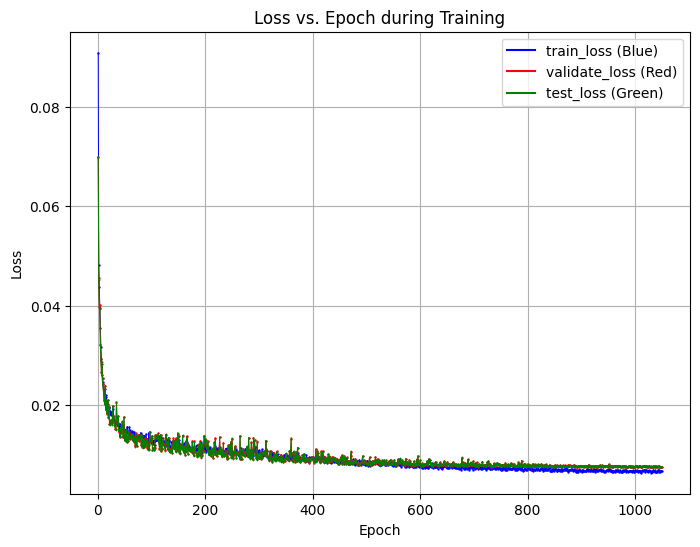

epoch:1099 train:0.0067 valid:0.0077 test:0.0076 lr:0.00028004 best_test:0.0075:  11%|█         | 1100/10001 [1:02:48<8:19:24,  3.37s/it]

Saving data...
MAE loss:  0.07437111437320709


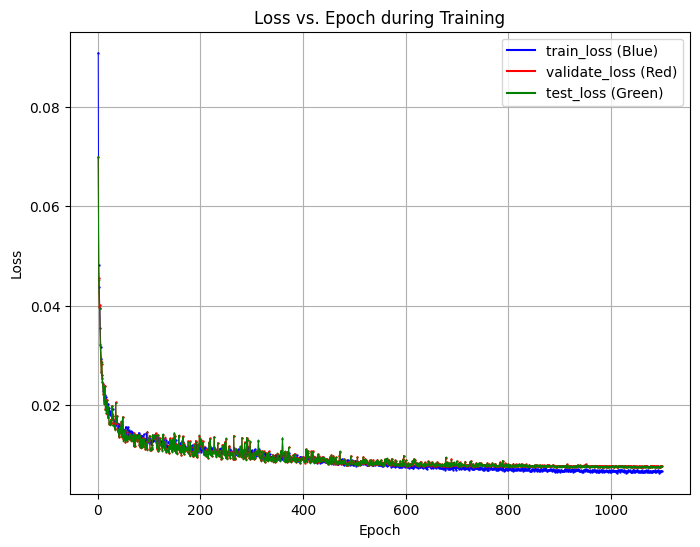

MAE=  0.07437111945021364
Saving model...


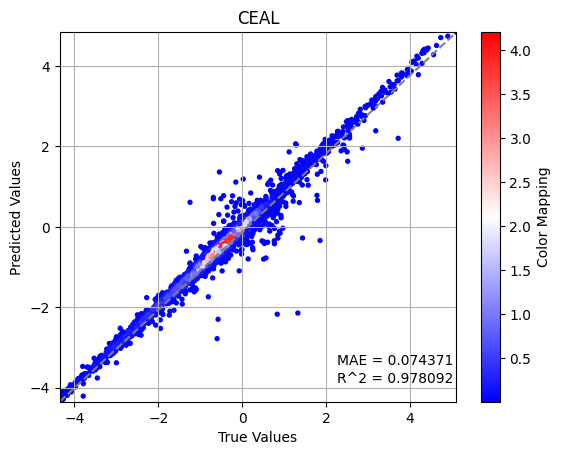

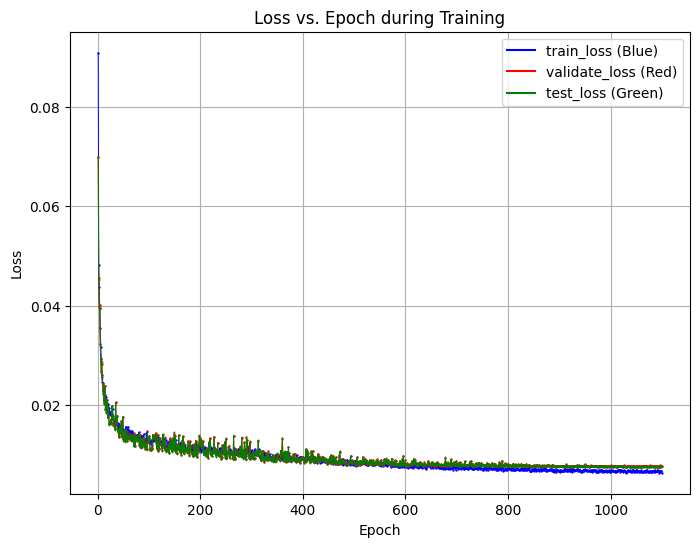

epoch:1149 train:0.0066 valid:0.0076 test:0.0075 lr:0.00020233 best_test:0.0075:  11%|█▏        | 1150/10001 [1:05:38<8:16:41,  3.37s/it]

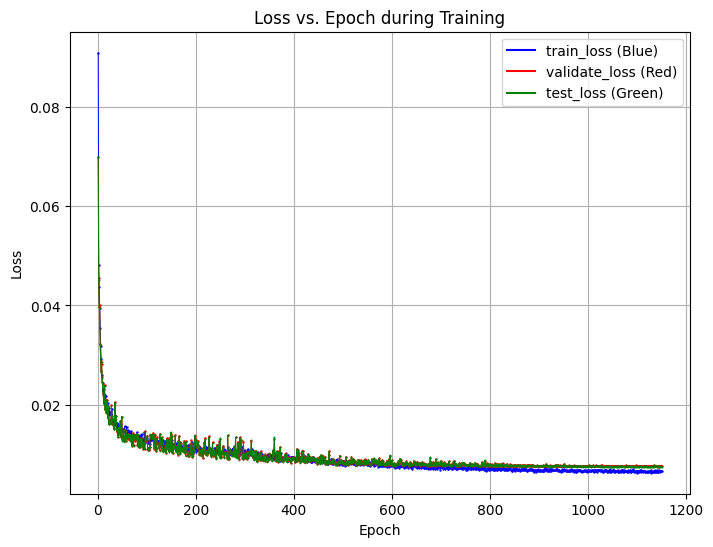

epoch:1199 train:0.0069 valid:0.0077 test:0.0077 lr:0.00014618 best_test:0.0075:  12%|█▏        | 1200/10001 [1:08:26<8:13:43,  3.37s/it]

Saving data...
MAE loss:  0.07463942468166351


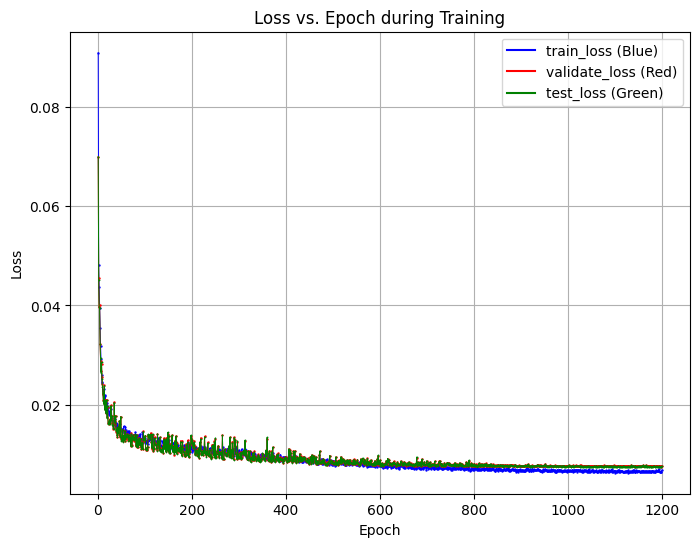

MAE=  0.0746394204936352
Saving model...


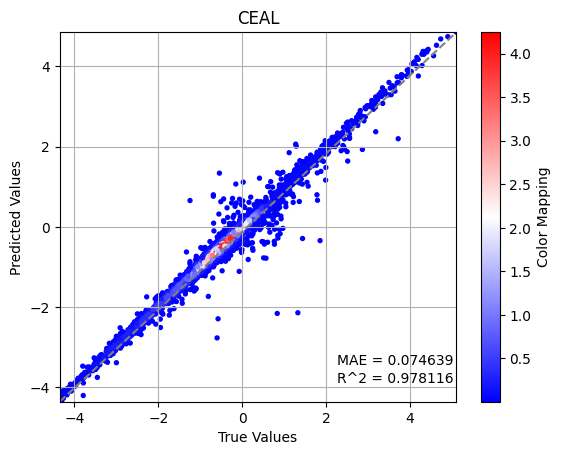

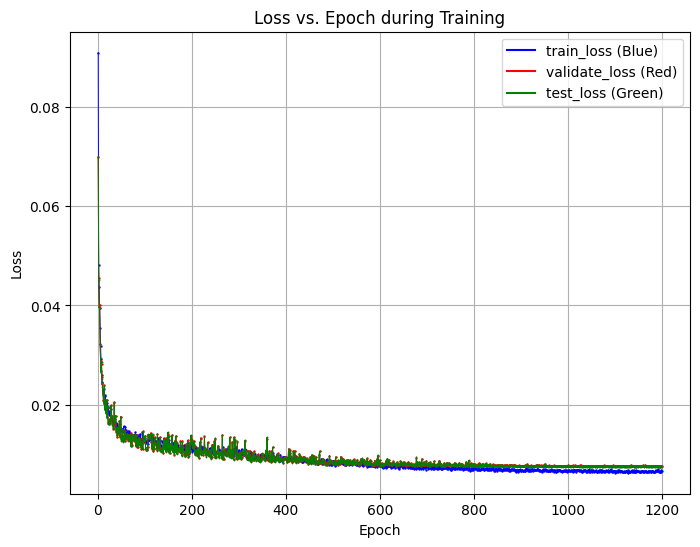

epoch:1249 train:0.0067 valid:0.0076 test:0.0075 lr:0.00012425 best_test:0.0075:  12%|█▏        | 1250/10001 [1:11:56<13:17:52,  5.47s/it]

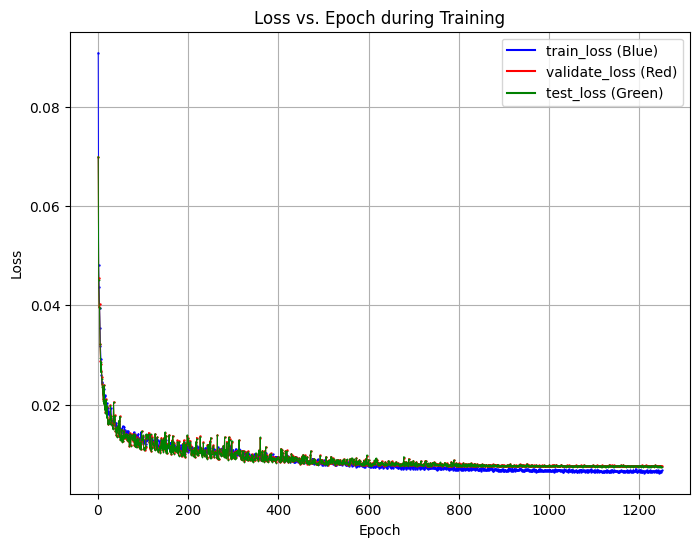

epoch:1299 train:0.0065 valid:0.0076 test:0.0075 lr:0.00010562 best_test:0.0075:  13%|█▎        | 1300/10001 [1:15:22<8:06:46,  3.36s/it] 

Saving data...
MAE loss:  0.07300841808319092


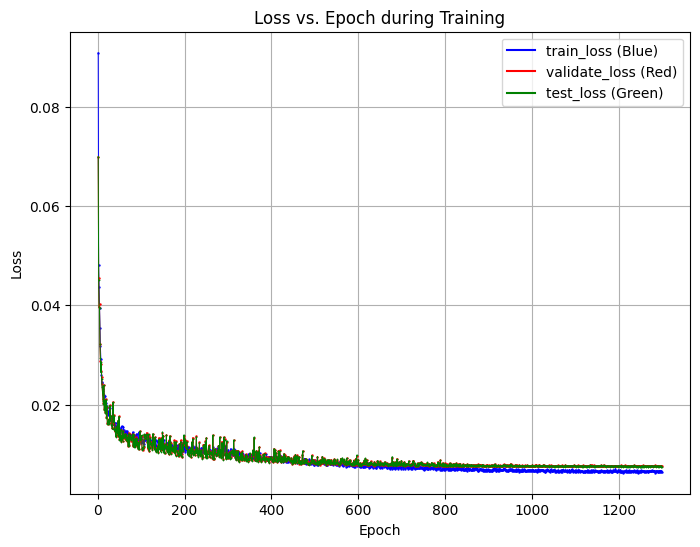

MAE=  0.0730084223639441
Saving model...


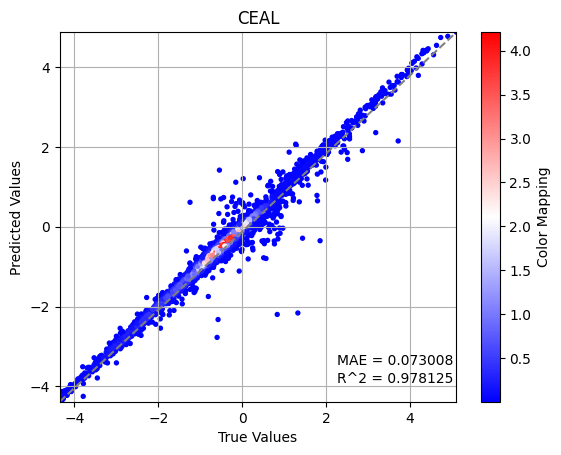

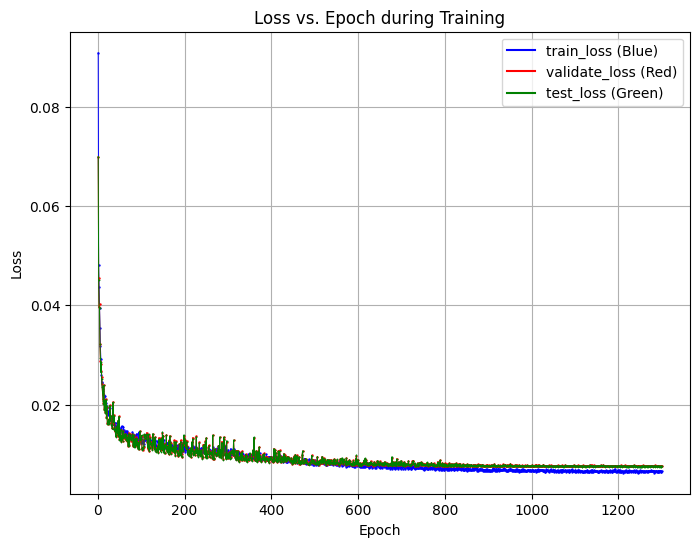

epoch:1349 train:0.0069 valid:0.0076 test:0.0075 lr:7.631e-05 best_test:0.0075:  13%|█▎        | 1350/10001 [1:18:11<8:02:19,  3.35s/it] 

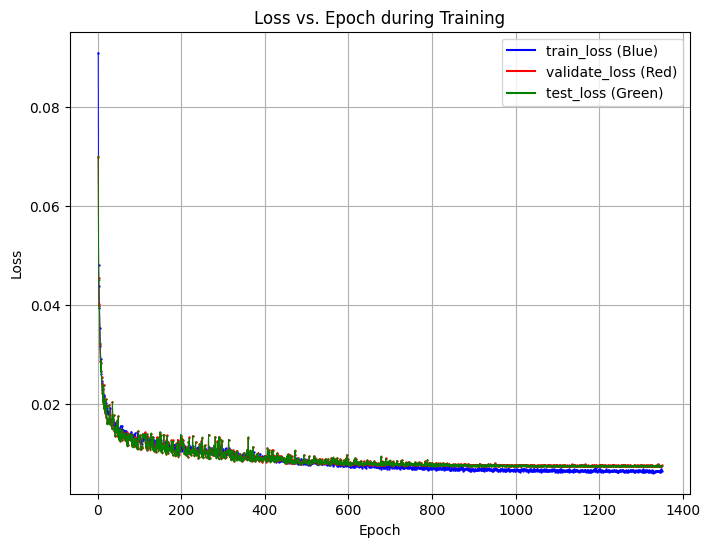

epoch:1399 train:0.0066 valid:0.0076 test:0.0075 lr:5.513e-05 best_test:0.0075:  14%|█▍        | 1400/10001 [1:20:59<8:02:51,  3.37s/it]

Saving data...
MAE loss:  0.07360289245843887


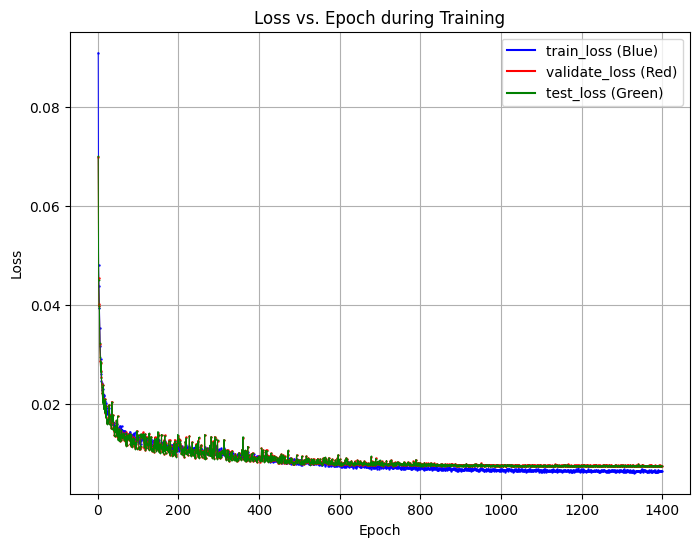

MAE=  0.073602895900059
Saving model...


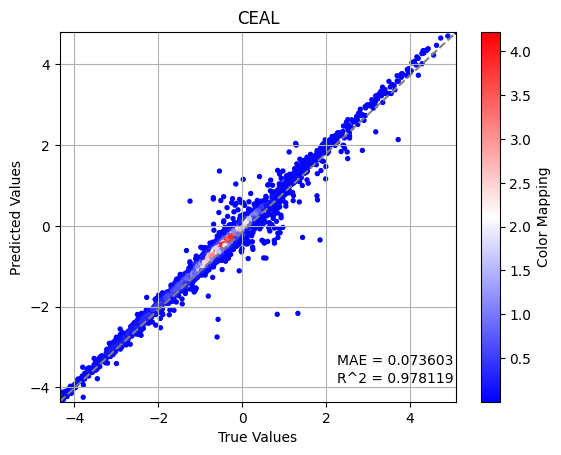

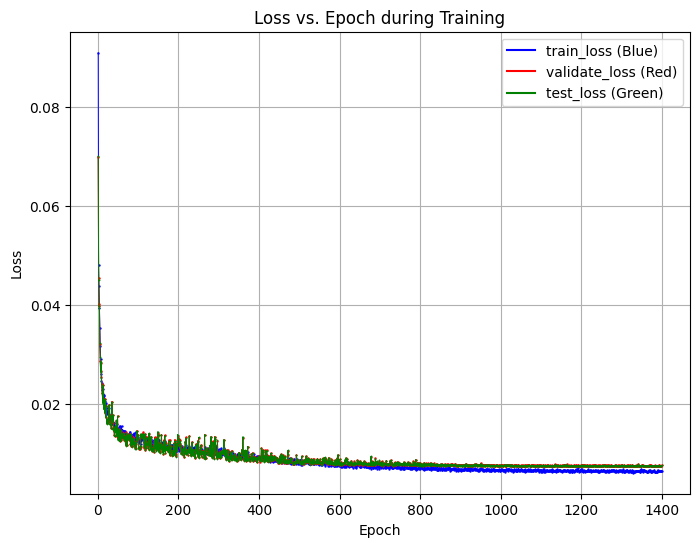

epoch:1449 train:0.0065 valid:0.0076 test:0.0075 lr:3.983e-05 best_test:0.0075:  14%|█▍        | 1450/10001 [1:23:49<7:59:18,  3.36s/it]

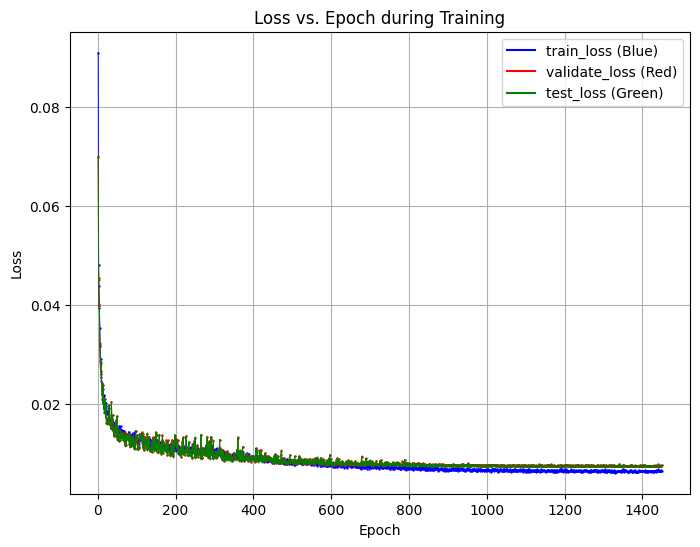

epoch:1499 train:0.0064 valid:0.0076 test:0.0076 lr:2.878e-05 best_test:0.0075:  15%|█▍        | 1500/10001 [1:26:37<7:56:59,  3.37s/it]

Saving data...
MAE loss:  0.07370110601186752


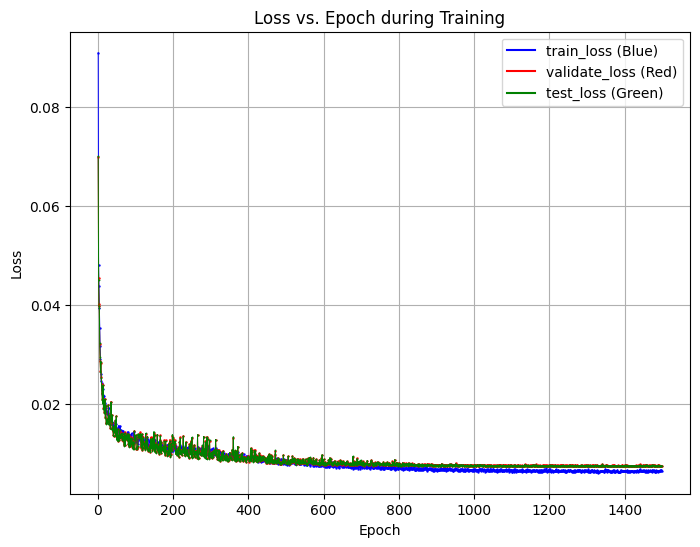

MAE=  0.07370110989578443
Saving model...


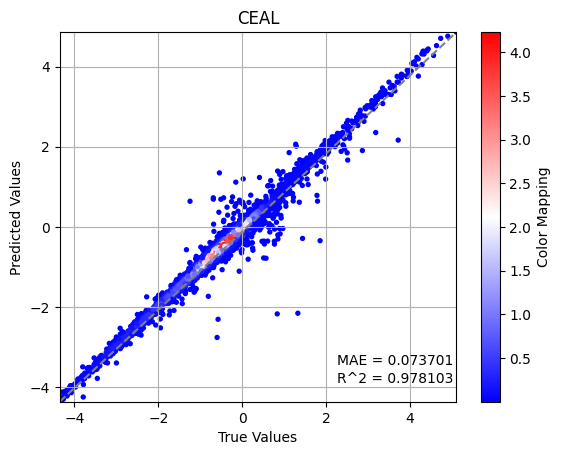

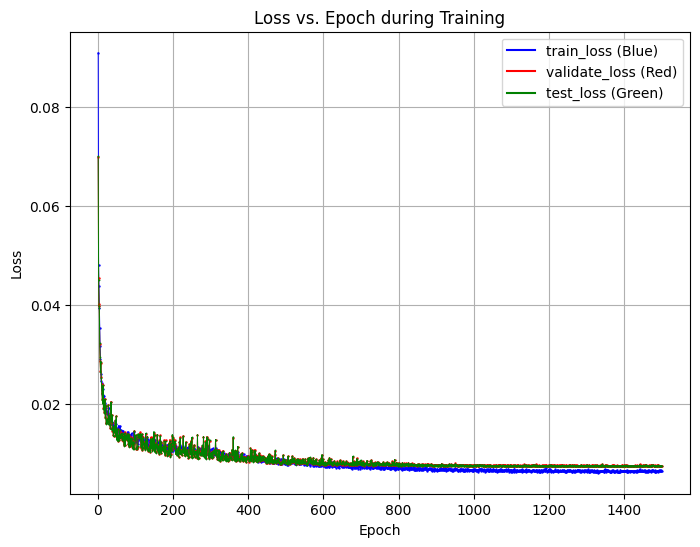

epoch:1549 train:0.0065 valid:0.0076 test:0.0075 lr:2.079e-05 best_test:0.0075:  15%|█▌        | 1550/10001 [1:29:27<7:54:35,  3.37s/it]

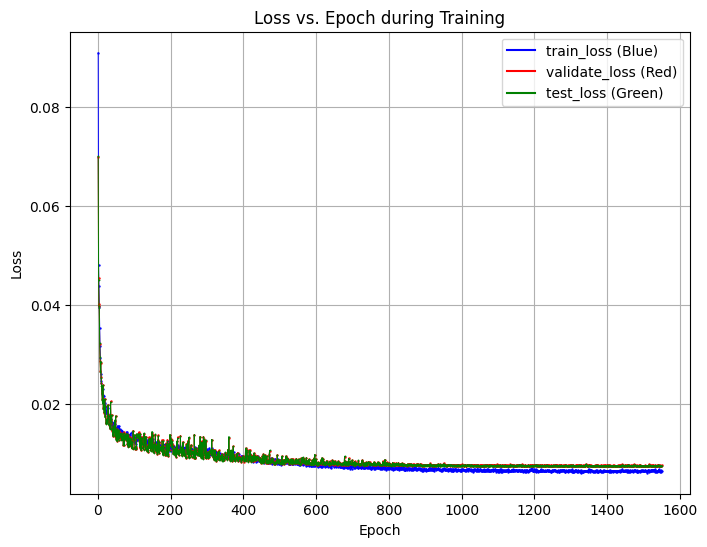

epoch:1554 train:0.0063 valid:0.0076 test:0.0075 lr:2.079e-05 best_test:0.0075:  16%|█▌        | 1555/10001 [1:29:44<7:55:23,  3.38s/it]

KeyboardInterrupt: 

In [7]:
epoch_start = 0 if epoch is None else epoch
epoch = epoch_start - 1
epochs = model_args["epochs"]

pbar = tqdm(total=(epochs + 1))
pbar.update(epoch_start + 1)

for epoch in range(epoch_start + 1, epochs + 1):

    # auto save and evaluate at every 100 epoch step
    save_result_data(
        args,
        epoch,
        model,
        train_losses,
        val_losses,
        test_losses,
        test_loader,
        test_dataset,
        device,
        optimizer,
        scheduler,
        result_path,
        regression_title=model_name,
        save_split=save_split,
        training=True,
    )

    model, train_loss = train_step(model, train_loader, train_dataset, optimizer, device)
    torch.cuda.empty_cache()
    val_loss, _, _ = test_evaluations(model, val_loader, validation_dataset, device, ret_data=False)
    torch.cuda.empty_cache()
    test_loss, _, _ = test_evaluations(model, test_loader, test_dataset, device, ret_data=False)
    torch.cuda.empty_cache()

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    plot_training_progress(len(train_losses), train_losses, val_losses, test_losses, split=show_plot_split,threshold=0.2)

    # save best model
    if test_best_loss is None or test_loss < test_best_loss:
        test_best_loss = test_loss
        # save_model_GCN(epoch, model, optimizer, scheduler, result_path)

    progress_msg = (
        "epoch:"
        + str(epoch)
        + " train:"
        + str(round(train_loss, 4))
        + " valid:"
        + str(round(val_loss, 4))
        + " test:"
        + str(round(test_loss, 4))
        + " lr:"
        + str(round(current_lr, 8))
        + " best_test:"
        + str(round(test_best_loss, 4))
    )
    pbar.set_description(progress_msg)
    pbar.update(1)

pbar.close()

Save model, results and checkpoint if need

In [ ]:
save_result_data(
    args,
    epoch,
    model, 
    train_losses,
    val_losses,
    test_losses,
    test_loader,
    test_dataset,
    optimizer,
    scheduler,
    device,
    result_path,
    regression_title=model_name,
)

Get test data distribution

In [ ]:
# reverse data scale
min, max = get_data_scale(args)

test_loss, test_out, test_y = test_evaluations(model, test_loader, test_dataset, device, ret_data=True)
test_out = reverse_min_max_scalar_1d(test_out, min, max)
test_y = reverse_min_max_scalar_1d(test_y, min, max)
loss = (test_out.squeeze() - test_y).abs().mean()
print(loss)

plt.hist(test_y.to("cpu"), range=(-5, 5), bins=50)